### Task Schedule:
1. 訓練模型,調整參數(預計使用lgb，速度較快)(更:使用catboost,效果較好)
2. 嘗試使用不同模型,做Ensamble(blending, stacking)
3. Anomaly detection

### 注意事項:
1. 因為test data和train data時間不相關,在驗證時採取前60天訓練61~90天驗證,但仍需小心時間差異造成的影響
2. Anomaly detection: 看這類的模型能不能取代boosting(似乎是不行，盜刷數據並沒有那麼Anomaly）,但可以嘗試將Anomaly結果當成新feature

### <font color=green>Results:</font>

#### Catboost:
    * FE1~4,catboost訓練 validation:0.5, LB:0.55

#### LGB:
    * 不做處理,直接丟lgb訓練 leaderboard score:0.45

## 讀取,轉換字串成可以訓練的資料

In [48]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
data_path = '../data'

random_seed = 2000

In [50]:
data_list=['raw_data.csv','FE_data1.csv','FE_data2.csv','FE_data4.csv']

data=[]
for d in data_list:
    x = pd.read_csv('../data/{}'.format(d),index_col=False)
    print(d,x.shape)
    x_null = x.isnull().sum()
    print("Null columns:\n",x_null[x_null>0])
    
    if (d=='FE_data1.csv') or (d=='FE_data2.csv'):
        x=x.fillna(value=-1)
        
    data.append(x)
    

raw_data.csv (1943452, 23)
Null columns:
 fraud_ind    421665
dtype: int64
FE_data1.csv (1943452, 54)
Null columns:
 cano_conam_skew       93942
cano_conam_kurt      156402
cano_conam_var        39970
bacno_locdt_skew      60927
bacno_locdt_kurt     104832
cano_locdt_skew       93942
cano_locdt_kurt      156402
mchno_fraud_mean    1204852
mcc_fraud_mean      1680560
acqic_fraud_mean    1643540
dtype: int64
FE_data2.csv (1943452, 8)
Null columns:
 Series([], dtype: int64)
FE_data4.csv (1943452, 6)
Null columns:
 Series([], dtype: int64)


In [51]:
all_data = pd.concat(data,axis=1)

all_data_numsum = all_data.isnull().sum()
print('ALL data null:')
print(all_data_numsum[all_data_numsum>0])

ALL data null:
fraud_ind    421665
dtype: int64


In [109]:
## 除掉一些可能會overfit,distribution不同,受時間影響大的feature

delete_list1 = ['bacno','locdt','loctm','cano','fraud_ind']
delete_list2 = ['mchno','acqic','mcc']
delete_list3 = ['stocn','scity','csmcu']
delete_list4 = ['iterm']
delete_list5 = ['contp','etymd','hcefg','insfg','ovrlt','flbmk','flg_3dsmk']
delete_list6 = ['mchno_fraud_mean','mcc_fraud_mean','acqic_fraud_mean']
delete_list7 = ['bacno_locdt_skew','bacno_locdt_kurt','cano_locdt_skew','cano_locdt_kurt']

delete_list = delete_list1+delete_list2+delete_list3+delete_list4+delete_list6+['txkey']+delete_list7

In [53]:
category_list=['csmcu','hcefg','stscd','scity','stocn','mcc','acqic','mchno','etymd','contp',\
              'stocn_bin','scity_bin','csmcu_bin','txkey_bin']
all_data[category_list]=all_data[category_list].astype('category')

In [54]:
## 切三種不同的訓練集驗證

X_train1 = all_data[all_data['locdt']<=60].drop(columns=delete_list)
y_train1 = all_data[all_data['locdt']<=60]['fraud_ind']
X_test1 = all_data[(all_data['locdt']>60) & (all_data['locdt']<=90)].drop(columns=delete_list)
y_test1 = all_data[(all_data['locdt']>60) & (all_data['locdt']<=90)]['fraud_ind']

X_train2 = all_data[all_data['locdt']<=45].drop(columns=delete_list)
y_train2 = all_data[all_data['locdt']<=45]['fraud_ind']
X_test2 = all_data[(all_data['locdt']>45) & (all_data['locdt']<=90)].drop(columns=delete_list)
y_test2 = all_data[(all_data['locdt']>45) & (all_data['locdt']<=90)]['fraud_ind']

X_train3 = all_data[all_data['locdt']<=30].drop(columns=delete_list)
y_train3 = all_data[all_data['locdt']<=30]['fraud_ind']
X_test3 = all_data[(all_data['locdt']>30) & (all_data['locdt']<=90)].drop(columns=delete_list)
y_test3 = all_data[(all_data['locdt']>30) & (all_data['locdt']<=90)]['fraud_ind']


test_data_txkey = all_data[all_data['locdt']>90]['txkey'].copy().values
X_train_all = all_data[all_data['locdt']<=90].drop(columns=delete_list) 
y_train_all = all_data[all_data['locdt']<=90]['fraud_ind'] 
X_test_all = all_data[all_data['locdt']>90].drop(columns=delete_list) 
# y_test_all = all_data[all_data['locdt']>90]['fraud_ind'] 

## Train on catboost
* https://catboost.ai/docs/concepts/python-reference_parameters-list.html
* 研究有哪些可以用的function

In [99]:
categorical_features_indices = np.where(X_train1.columns.isin(category_list))[0]

print(X_train1.dtypes[categorical_features_indices])
category_list2 = X_train1.dtypes[categorical_features_indices].index

contp        category
etymd        category
hcefg        category
stscd        category
stocn_bin    category
scity_bin    category
csmcu_bin    category
txkey_bin    category
dtype: object


In [102]:
param_cat={
    'loss_function':'Logloss',
    'eval_metric':'F1',
    
    'iterations':1000,
    'learning_rate':0.1,
    'l2_leaf_reg':3,
#     'sampling_frequency':'PerTreeLevel',
    
    'depth':6,
    'one_hot_max_size':300,
    
#     'min_data_in_leaf':1,
#     'max_leaves':31,
#     'task_type':"GPU",
#     'devices':1',
    'rsm':1,
    'scale_pos_weight':1,
    'target_border':0.5,
    'random_seed':random_seed,
    'verbose':True    
}

In [103]:
from catboost import CatBoostClassifier, Pool

print(categorical_features_indices)

model = CatBoostClassifier(**param_cat)

model.fit(
    X_train1, y_train1,
    cat_features=categorical_features_indices,    
    eval_set=(X_test1, y_test1),
    early_stopping_rounds=200,
#     use_best_model=True,
    silent=False,
#     plot=True,
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())


# preds_class = model.predict(test_data)
# preds_proba = model.predict_proba(test_data)

[ 1  3  6  9 10 11 12 13]
0:	learn: 0.5183719	test: 0.2747144	best: 0.2747144 (0)	total: 351ms	remaining: 5m 50s
1:	learn: 0.5263383	test: 0.3146914	best: 0.3146914 (1)	total: 726ms	remaining: 6m 2s
2:	learn: 0.5559709	test: 0.3266854	best: 0.3266854 (2)	total: 1.09s	remaining: 6m 4s
3:	learn: 0.5741699	test: 0.3831978	best: 0.3831978 (3)	total: 1.45s	remaining: 6m
4:	learn: 0.5888140	test: 0.3906250	best: 0.3906250 (4)	total: 1.81s	remaining: 5m 59s
5:	learn: 0.5985706	test: 0.4179594	best: 0.4179594 (5)	total: 2.18s	remaining: 6m 1s
6:	learn: 0.6045430	test: 0.4237352	best: 0.4237352 (6)	total: 2.53s	remaining: 5m 59s
7:	learn: 0.6100133	test: 0.4421336	best: 0.4421336 (7)	total: 2.85s	remaining: 5m 53s
8:	learn: 0.6137920	test: 0.4382346	best: 0.4421336 (7)	total: 3.19s	remaining: 5m 51s
9:	learn: 0.6156997	test: 0.4380403	best: 0.4421336 (7)	total: 3.55s	remaining: 5m 51s
10:	learn: 0.6187073	test: 0.4474994	best: 0.4474994 (10)	total: 3.91s	remaining: 5m 51s
11:	learn: 0.6193889	t

93:	learn: 0.7162152	test: 0.5268392	best: 0.5268987 (92)	total: 39.3s	remaining: 6m 19s
94:	learn: 0.7164352	test: 0.5266960	best: 0.5268987 (92)	total: 40s	remaining: 6m 21s
95:	learn: 0.7171413	test: 0.5267787	best: 0.5268987 (92)	total: 40.7s	remaining: 6m 23s
96:	learn: 0.7173452	test: 0.5265532	best: 0.5268987 (92)	total: 41.4s	remaining: 6m 25s
97:	learn: 0.7172302	test: 0.5275644	best: 0.5275644 (97)	total: 42s	remaining: 6m 26s
98:	learn: 0.7183718	test: 0.5281825	best: 0.5281825 (98)	total: 42.6s	remaining: 6m 28s
99:	learn: 0.7191739	test: 0.5273609	best: 0.5281825 (98)	total: 43.3s	remaining: 6m 29s
100:	learn: 0.7198429	test: 0.5275467	best: 0.5281825 (98)	total: 43.7s	remaining: 6m 28s
101:	learn: 0.7206007	test: 0.5270969	best: 0.5281825 (98)	total: 44s	remaining: 6m 27s
102:	learn: 0.7203171	test: 0.5281619	best: 0.5281825 (98)	total: 44.3s	remaining: 6m 25s
103:	learn: 0.7214148	test: 0.5275936	best: 0.5281825 (98)	total: 44.6s	remaining: 6m 24s
104:	learn: 0.7215774	t

184:	learn: 0.7563297	test: 0.5318989	best: 0.5368628 (152)	total: 1m 19s	remaining: 5m 48s
185:	learn: 0.7565901	test: 0.5326731	best: 0.5368628 (152)	total: 1m 19s	remaining: 5m 47s
186:	learn: 0.7570575	test: 0.5319699	best: 0.5368628 (152)	total: 1m 19s	remaining: 5m 46s
187:	learn: 0.7572159	test: 0.5320844	best: 0.5368628 (152)	total: 1m 20s	remaining: 5m 45s
188:	learn: 0.7577010	test: 0.5305466	best: 0.5368628 (152)	total: 1m 20s	remaining: 5m 45s
189:	learn: 0.7576646	test: 0.5305466	best: 0.5368628 (152)	total: 1m 20s	remaining: 5m 45s
190:	learn: 0.7589004	test: 0.5316890	best: 0.5368628 (152)	total: 1m 21s	remaining: 5m 44s
191:	learn: 0.7588176	test: 0.5312902	best: 0.5368628 (152)	total: 1m 21s	remaining: 5m 43s
192:	learn: 0.7593045	test: 0.5319331	best: 0.5368628 (152)	total: 1m 22s	remaining: 5m 42s
193:	learn: 0.7596591	test: 0.5315778	best: 0.5368628 (152)	total: 1m 22s	remaining: 5m 42s
194:	learn: 0.7598168	test: 0.5318055	best: 0.5368628 (152)	total: 1m 22s	remain

274:	learn: 0.7781613	test: 0.5379619	best: 0.5383795 (271)	total: 1m 58s	remaining: 5m 12s
275:	learn: 0.7780995	test: 0.5368242	best: 0.5383795 (271)	total: 1m 59s	remaining: 5m 12s
276:	learn: 0.7782644	test: 0.5371100	best: 0.5383795 (271)	total: 1m 59s	remaining: 5m 12s
277:	learn: 0.7783716	test: 0.5375679	best: 0.5383795 (271)	total: 2m	remaining: 5m 12s
278:	learn: 0.7786271	test: 0.5377238	best: 0.5383795 (271)	total: 2m	remaining: 5m 11s
279:	learn: 0.7790965	test: 0.5379046	best: 0.5383795 (271)	total: 2m 1s	remaining: 5m 11s
280:	learn: 0.7792776	test: 0.5374787	best: 0.5383795 (271)	total: 2m 1s	remaining: 5m 10s
281:	learn: 0.7797427	test: 0.5380603	best: 0.5383795 (271)	total: 2m 1s	remaining: 5m 10s
282:	learn: 0.7800230	test: 0.5380279	best: 0.5383795 (271)	total: 2m 2s	remaining: 5m 9s
283:	learn: 0.7824446	test: 0.5382569	best: 0.5383795 (271)	total: 2m 2s	remaining: 5m 8s
284:	learn: 0.7825411	test: 0.5382243	best: 0.5383795 (271)	total: 2m 2s	remaining: 5m 8s
285:	

364:	learn: 0.7946294	test: 0.5390551	best: 0.5408271 (328)	total: 2m 37s	remaining: 4m 34s
365:	learn: 0.7950576	test: 0.5387298	best: 0.5408271 (328)	total: 2m 38s	remaining: 4m 34s
366:	learn: 0.7953969	test: 0.5391121	best: 0.5408271 (328)	total: 2m 38s	remaining: 4m 33s
367:	learn: 0.7955147	test: 0.5394208	best: 0.5408271 (328)	total: 2m 38s	remaining: 4m 32s
368:	learn: 0.7954846	test: 0.5397127	best: 0.5408271 (328)	total: 2m 39s	remaining: 4m 32s
369:	learn: 0.7958981	test: 0.5391763	best: 0.5408271 (328)	total: 2m 39s	remaining: 4m 31s
370:	learn: 0.7959416	test: 0.5391763	best: 0.5408271 (328)	total: 2m 39s	remaining: 4m 31s
371:	learn: 0.7957803	test: 0.5395251	best: 0.5408271 (328)	total: 2m 40s	remaining: 4m 31s
372:	learn: 0.7958096	test: 0.5396222	best: 0.5408271 (328)	total: 2m 41s	remaining: 4m 31s
373:	learn: 0.7959574	test: 0.5396222	best: 0.5408271 (328)	total: 2m 42s	remaining: 4m 31s
374:	learn: 0.7958681	test: 0.5389562	best: 0.5408271 (328)	total: 2m 42s	remain

454:	learn: 0.8056064	test: 0.5396859	best: 0.5419437 (392)	total: 3m 18s	remaining: 3m 57s
455:	learn: 0.8055464	test: 0.5393635	best: 0.5419437 (392)	total: 3m 18s	remaining: 3m 56s
456:	learn: 0.8057070	test: 0.5396361	best: 0.5419437 (392)	total: 3m 19s	remaining: 3m 56s
457:	learn: 0.8058817	test: 0.5395232	best: 0.5419437 (392)	total: 3m 19s	remaining: 3m 55s
458:	learn: 0.8058533	test: 0.5406083	best: 0.5419437 (392)	total: 3m 19s	remaining: 3m 55s
459:	learn: 0.8062169	test: 0.5405518	best: 0.5419437 (392)	total: 3m 20s	remaining: 3m 54s
460:	learn: 0.8064634	test: 0.5409699	best: 0.5419437 (392)	total: 3m 20s	remaining: 3m 54s
461:	learn: 0.8067227	test: 0.5397953	best: 0.5419437 (392)	total: 3m 20s	remaining: 3m 53s
462:	learn: 0.8063279	test: 0.5403260	best: 0.5419437 (392)	total: 3m 21s	remaining: 3m 53s
463:	learn: 0.8065919	test: 0.5392577	best: 0.5419437 (392)	total: 3m 21s	remaining: 3m 53s
464:	learn: 0.8067816	test: 0.5408121	best: 0.5419437 (392)	total: 3m 22s	remain

544:	learn: 0.8166576	test: 0.5417621	best: 0.5419437 (392)	total: 3m 57s	remaining: 3m 18s
545:	learn: 0.8169127	test: 0.5422917	best: 0.5422917 (545)	total: 3m 57s	remaining: 3m 17s
546:	learn: 0.8169690	test: 0.5425177	best: 0.5425177 (546)	total: 3m 58s	remaining: 3m 17s
547:	learn: 0.8170714	test: 0.5425953	best: 0.5425953 (547)	total: 3m 59s	remaining: 3m 17s
548:	learn: 0.8171410	test: 0.5427083	best: 0.5427083 (548)	total: 3m 59s	remaining: 3m 17s
549:	learn: 0.8173262	test: 0.5420269	best: 0.5427083 (548)	total: 4m	remaining: 3m 16s
550:	learn: 0.8175575	test: 0.5423658	best: 0.5427083 (548)	total: 4m 1s	remaining: 3m 16s
551:	learn: 0.8176466	test: 0.5423482	best: 0.5427083 (548)	total: 4m 1s	remaining: 3m 15s
552:	learn: 0.8178052	test: 0.5421047	best: 0.5427083 (548)	total: 4m 1s	remaining: 3m 15s
553:	learn: 0.8178614	test: 0.5417621	best: 0.5427083 (548)	total: 4m 2s	remaining: 3m 14s
554:	learn: 0.8180332	test: 0.5408609	best: 0.5427083 (548)	total: 4m 2s	remaining: 3m 1

634:	learn: 0.8263135	test: 0.5444676	best: 0.5457393 (622)	total: 4m 37s	remaining: 2m 39s
635:	learn: 0.8261939	test: 0.5444491	best: 0.5457393 (622)	total: 4m 38s	remaining: 2m 39s
636:	learn: 0.8263889	test: 0.5443923	best: 0.5457393 (622)	total: 4m 38s	remaining: 2m 38s
637:	learn: 0.8264612	test: 0.5440317	best: 0.5457393 (622)	total: 4m 38s	remaining: 2m 38s
638:	learn: 0.8262992	test: 0.5435801	best: 0.5457393 (622)	total: 4m 39s	remaining: 2m 37s
639:	learn: 0.8264014	test: 0.5438834	best: 0.5457393 (622)	total: 4m 39s	remaining: 2m 37s
640:	learn: 0.8268556	test: 0.5436752	best: 0.5457393 (622)	total: 4m 40s	remaining: 2m 37s
641:	learn: 0.8271101	test: 0.5432382	best: 0.5457393 (622)	total: 4m 41s	remaining: 2m 36s
642:	learn: 0.8274416	test: 0.5429911	best: 0.5457393 (622)	total: 4m 41s	remaining: 2m 36s
643:	learn: 0.8272497	test: 0.5433333	best: 0.5457393 (622)	total: 4m 42s	remaining: 2m 36s
644:	learn: 0.8272497	test: 0.5434466	best: 0.5457393 (622)	total: 4m 43s	remain

724:	learn: 0.8354294	test: 0.5414583	best: 0.5457393 (622)	total: 5m 18s	remaining: 2m
725:	learn: 0.8351648	test: 0.5417057	best: 0.5457393 (622)	total: 5m 18s	remaining: 2m
726:	learn: 0.8352606	test: 0.5415538	best: 0.5457393 (622)	total: 5m 18s	remaining: 1m 59s
727:	learn: 0.8353746	test: 0.5418965	best: 0.5457393 (622)	total: 5m 19s	remaining: 1m 59s
728:	learn: 0.8354713	test: 0.5420658	best: 0.5457393 (622)	total: 5m 19s	remaining: 1m 58s
729:	learn: 0.8357413	test: 0.5418011	best: 0.5457393 (622)	total: 5m 19s	remaining: 1m 58s
730:	learn: 0.8358908	test: 0.5419529	best: 0.5457393 (622)	total: 5m 20s	remaining: 1m 57s
731:	learn: 0.8359327	test: 0.5418576	best: 0.5457393 (622)	total: 5m 20s	remaining: 1m 57s
732:	learn: 0.8358542	test: 0.5418186	best: 0.5457393 (622)	total: 5m 20s	remaining: 1m 56s
733:	learn: 0.8360048	test: 0.5420833	best: 0.5457393 (622)	total: 5m 21s	remaining: 1m 56s
734:	learn: 0.8361908	test: 0.5419315	best: 0.5457393 (622)	total: 5m 21s	remaining: 1m 

814:	learn: 0.8418748	test: 0.5460027	best: 0.5465709 (800)	total: 5m 56s	remaining: 1m 20s
815:	learn: 0.8419353	test: 0.5460218	best: 0.5465709 (800)	total: 5m 56s	remaining: 1m 20s
816:	learn: 0.8419466	test: 0.5459645	best: 0.5465709 (800)	total: 5m 57s	remaining: 1m 19s
817:	learn: 0.8426527	test: 0.5457003	best: 0.5465709 (800)	total: 5m 57s	remaining: 1m 19s
818:	learn: 0.8427244	test: 0.5460588	best: 0.5465709 (800)	total: 5m 58s	remaining: 1m 19s
819:	learn: 0.8427547	test: 0.5462290	best: 0.5465709 (800)	total: 5m 58s	remaining: 1m 18s
820:	learn: 0.8432603	test: 0.5455866	best: 0.5465709 (800)	total: 5m 59s	remaining: 1m 18s
821:	learn: 0.8431471	test: 0.5454168	best: 0.5465709 (800)	total: 6m	remaining: 1m 18s
822:	learn: 0.8432491	test: 0.5454734	best: 0.5465709 (800)	total: 6m 1s	remaining: 1m 17s
823:	learn: 0.8433398	test: 0.5448326	best: 0.5465709 (800)	total: 6m 1s	remaining: 1m 17s
824:	learn: 0.8434945	test: 0.5453791	best: 0.5465709 (800)	total: 6m 2s	remaining: 1m

905:	learn: 0.8504033	test: 0.5501966	best: 0.5505537 (904)	total: 6m 37s	remaining: 41.3s
906:	learn: 0.8504533	test: 0.5500466	best: 0.5505537 (904)	total: 6m 38s	remaining: 40.8s
907:	learn: 0.8506690	test: 0.5503675	best: 0.5505537 (904)	total: 6m 38s	remaining: 40.4s
908:	learn: 0.8506887	test: 0.5508387	best: 0.5508387 (908)	total: 6m 38s	remaining: 39.9s
909:	learn: 0.8508315	test: 0.5505955	best: 0.5508387 (908)	total: 6m 39s	remaining: 39.5s
910:	learn: 0.8510350	test: 0.5503675	best: 0.5508387 (908)	total: 6m 39s	remaining: 39s
911:	learn: 0.8509651	test: 0.5502382	best: 0.5508387 (908)	total: 6m 39s	remaining: 38.6s
912:	learn: 0.8509029	test: 0.5499378	best: 0.5508387 (908)	total: 6m 40s	remaining: 38.2s
913:	learn: 0.8508208	test: 0.5499741	best: 0.5508387 (908)	total: 6m 40s	remaining: 37.7s
914:	learn: 0.8508118	test: 0.5500673	best: 0.5508387 (908)	total: 6m 41s	remaining: 37.3s
915:	learn: 0.8511580	test: 0.5500673	best: 0.5508387 (908)	total: 6m 41s	remaining: 36.8s
9

996:	learn: 0.8550983	test: 0.5518453	best: 0.5533105 (955)	total: 7m 16s	remaining: 1.31s
997:	learn: 0.8550678	test: 0.5520736	best: 0.5533105 (955)	total: 7m 17s	remaining: 877ms
998:	learn: 0.8550276	test: 0.5519239	best: 0.5533105 (955)	total: 7m 18s	remaining: 439ms
999:	learn: 0.8550276	test: 0.5521307	best: 0.5533105 (955)	total: 7m 19s	remaining: 0us

bestTest = 0.5533105378
bestIteration = 955

Shrink model to first 956 iterations.
Model is fitted: True
Model params:
{'one_hot_max_size': 300, 'iterations': 1000, 'l2_leaf_reg': 5, 'scale_pos_weight': 1, 'target_border': 0.5, 'loss_function': 'Logloss', 'learning_rate': 0.1, 'eval_metric': 'F1', 'verbose': True, 'depth': 7, 'rsm': 1, 'random_seed': 2000}


In [104]:
train_pool=Pool(X_train1, y_train1, cat_features=categorical_features_indices)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

ecfg: 8.5385348279554
stocn_value_counts: 8.208326639728531
csmcu_value_counts: 6.795666864275341
etymd: 5.115592264750038
bacno_stocn_nunique: 4.0779950964017235
conam: 3.8480697414673384
stocn_cano_nunique: 3.264648224450035
bacno_cano_not1: 3.103959486286032
bacno_csmcu_nunique: 2.681551717159782
scity_cano_nunique: 2.537195885979895
cano_locdt_kurt: 2.524704633010302
cano_locdt_skew: 2.426800954112779
bacno_max_conam: 2.307842020288359
cano_conam_skew: 2.2932337238537506
bacno_mean_conam: 2.152809738613546
bacno_locdt_skew: 2.05432727830706
bacno_locdt_kurt: 1.9296288564697994
cano_conam_kurt: 1.8499390874386707
cano_lastlocdt: 1.7856232605386504
flg_3dsmk: 1.6953833313795796
conam_log: 1.6431524023101358
txkey_bin: 1.6383517443902877
cano_conam_var: 1.541271460787213
stocn_bin: 1.4275325153708471
loctm_hr: 1.37985595417423
cano_mean_conam: 1.3621443798940793
cano_lastlocdt2: 1.354113174180172
stocn_bacno_nunique: 1.325064393584089
bacno_ratio_ecfg: 1.2056979808003299
contp: 1.1482

In [ ]:
## 理論上th設0.5一定是最好的？

y_test1_pred = model.predict_proba(X_test1,verbose=True)[:,1]
th=0.5

y_test1_pred[y_test1_pred>th]=1
y_test1_pred[y_test1_pred<=th]=0
print(f1_score(y_test1, y_test1_pred))

In [55]:
model = CatBoostClassifier(**param_cat)

model.fit(
    X_train_all, y_train_all,
    cat_features=categorical_features_indices,    
    silent=False
)
y_test_pred_cat = model.predict_proba(X_test_all)[:,1]

print(X_test_all.index)

th=0.5
y_test_pred_cat[y_test_pred_cat>th]=1
y_test_pred_cat[y_test_pred_cat<=th]=0

0:	learn: 0.4808045	total: 348ms	remaining: 3m 28s
1:	learn: 0.4487908	total: 658ms	remaining: 3m 16s
2:	learn: 0.4477144	total: 986ms	remaining: 3m 16s
3:	learn: 0.4886304	total: 1.29s	remaining: 3m 12s
4:	learn: 0.4896011	total: 1.61s	remaining: 3m 11s
5:	learn: 0.4949289	total: 1.93s	remaining: 3m 10s
6:	learn: 0.5065112	total: 2.22s	remaining: 3m 8s
7:	learn: 0.5006379	total: 2.52s	remaining: 3m 6s
8:	learn: 0.5124105	total: 2.82s	remaining: 3m 5s
9:	learn: 0.5105654	total: 3.12s	remaining: 3m 4s
10:	learn: 0.5168821	total: 3.41s	remaining: 3m 2s
11:	learn: 0.5254897	total: 3.69s	remaining: 3m
12:	learn: 0.5344502	total: 4s	remaining: 3m
13:	learn: 0.5289366	total: 4.3s	remaining: 3m
14:	learn: 0.5377514	total: 4.61s	remaining: 2m 59s
15:	learn: 0.5325824	total: 4.91s	remaining: 2m 59s
16:	learn: 0.5428251	total: 5.22s	remaining: 2m 58s
17:	learn: 0.5432009	total: 5.52s	remaining: 2m 58s
18:	learn: 0.5457119	total: 5.81s	remaining: 2m 57s
19:	learn: 0.5445966	total: 6.1s	remaining:

158:	learn: 0.6757969	total: 47.7s	remaining: 2m 12s
159:	learn: 0.6755755	total: 48s	remaining: 2m 11s
160:	learn: 0.6760311	total: 48.3s	remaining: 2m 11s
161:	learn: 0.6763063	total: 48.6s	remaining: 2m 11s
162:	learn: 0.6777698	total: 48.9s	remaining: 2m 11s
163:	learn: 0.6775532	total: 49.2s	remaining: 2m 10s
164:	learn: 0.6778497	total: 49.5s	remaining: 2m 10s
165:	learn: 0.6784244	total: 49.8s	remaining: 2m 10s
166:	learn: 0.6792149	total: 50s	remaining: 2m 9s
167:	learn: 0.6788367	total: 50.4s	remaining: 2m 9s
168:	learn: 0.6792284	total: 50.6s	remaining: 2m 9s
169:	learn: 0.6799964	total: 50.9s	remaining: 2m 8s
170:	learn: 0.6805684	total: 51.2s	remaining: 2m 8s
171:	learn: 0.6810550	total: 51.5s	remaining: 2m 8s
172:	learn: 0.6815340	total: 51.8s	remaining: 2m 7s
173:	learn: 0.6815313	total: 52.2s	remaining: 2m 7s
174:	learn: 0.6815516	total: 52.5s	remaining: 2m 7s
175:	learn: 0.6816381	total: 52.8s	remaining: 2m 7s
176:	learn: 0.6823256	total: 53.1s	remaining: 2m 6s
177:	lea

313:	learn: 0.7137321	total: 1m 34s	remaining: 1m 26s
314:	learn: 0.7138196	total: 1m 35s	remaining: 1m 25s
315:	learn: 0.7136574	total: 1m 35s	remaining: 1m 25s
316:	learn: 0.7140944	total: 1m 35s	remaining: 1m 25s
317:	learn: 0.7145435	total: 1m 35s	remaining: 1m 25s
318:	learn: 0.7149427	total: 1m 36s	remaining: 1m 24s
319:	learn: 0.7154533	total: 1m 36s	remaining: 1m 24s
320:	learn: 0.7159596	total: 1m 36s	remaining: 1m 24s
321:	learn: 0.7162582	total: 1m 37s	remaining: 1m 23s
322:	learn: 0.7171653	total: 1m 37s	remaining: 1m 23s
323:	learn: 0.7171949	total: 1m 37s	remaining: 1m 23s
324:	learn: 0.7174437	total: 1m 38s	remaining: 1m 22s
325:	learn: 0.7172814	total: 1m 38s	remaining: 1m 22s
326:	learn: 0.7171456	total: 1m 38s	remaining: 1m 22s
327:	learn: 0.7173572	total: 1m 39s	remaining: 1m 22s
328:	learn: 0.7173900	total: 1m 39s	remaining: 1m 21s
329:	learn: 0.7175555	total: 1m 39s	remaining: 1m 21s
330:	learn: 0.7177759	total: 1m 40s	remaining: 1m 21s
331:	learn: 0.7180232	total:

468:	learn: 0.7337571	total: 2m 22s	remaining: 39.7s
469:	learn: 0.7338030	total: 2m 22s	remaining: 39.4s
470:	learn: 0.7339734	total: 2m 22s	remaining: 39.1s
471:	learn: 0.7337571	total: 2m 23s	remaining: 38.8s
472:	learn: 0.7340542	total: 2m 23s	remaining: 38.5s
473:	learn: 0.7341940	total: 2m 23s	remaining: 38.2s
474:	learn: 0.7339027	total: 2m 23s	remaining: 37.9s
475:	learn: 0.7339486	total: 2m 24s	remaining: 37.6s
476:	learn: 0.7340062	total: 2m 24s	remaining: 37.3s
477:	learn: 0.7341001	total: 2m 24s	remaining: 37s
478:	learn: 0.7345730	total: 2m 25s	remaining: 36.7s
479:	learn: 0.7342973	total: 2m 25s	remaining: 36.4s
480:	learn: 0.7345367	total: 2m 25s	remaining: 36.1s
481:	learn: 0.7346704	total: 2m 26s	remaining: 35.8s
482:	learn: 0.7347584	total: 2m 26s	remaining: 35.5s
483:	learn: 0.7350069	total: 2m 26s	remaining: 35.2s
484:	learn: 0.7350280	total: 2m 26s	remaining: 34.9s
485:	learn: 0.7352156	total: 2m 27s	remaining: 34.5s
486:	learn: 0.7354149	total: 2m 27s	remaining: 3

## write csv

In [77]:
result = y_test_pred_cat
print('{}: prediction positive ratio'.format(result.sum()/result.shape[0]))
print('{}: training positive ratio'.format(y_train_all.sum()/y_train_all.shape[0]))


submit_file_name='submit_cat.csv'
import csv
with open('../prediction/{}'.format(submit_file_name),'w') as f:
    writer = csv.writer(f)
    writer.writerow(['txkey','fraud_ind'])
    for i in range(result.shape[0]):
        writer.writerow([test_data_txkey[i], result[i]])
        
with open('../prediction/log.txt','w') as f:
    print('{}'.format(submit_file_name),file=f)
    print('delete_list:\n{}'.format(delete_list),file=f)

0.010010316246309273: prediction positive ratio
0.013375722095142093: training positive ratio


## Anomaly detection
* one class svm
* isolation tree
* replicator NN
* Kmeans?
* KNN(take too much time)

## 製作特徵
XGB, LGB, PCA, Isolation Forest, Kmean距離？, oneclass SVM?
當作新feature

In [ ]:
import xgboost as xgb
param_dist_xgb = {'learning_rate':0.01, #默认0.3
              'n_estimators':1000, #树的个数
#               'max_depth':5,
#               'min_child_weight':1,
#               'gamma':0.2,
#               'subsample':0.8,
#               'colsample_bytree':0.8,
#               'objective': 'binary:logistic', #逻辑回归损失函数
#               'nthread':4,  #cpu线程数
#               'scale_pos_weight':1,
              'seed':random_seed}  #随机种子

evals_result = {}

xgb_clf = xgb.XGBClassifier(**param_dist_xgb)
xgb_clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric=lgb_f1_score,
        early_stopping_rounds=600,
        verbose=True,
#         callbacks=[xgb.record_evaluation(evals_result)]
        )

print('F1',f1_score(y_test, xgb_clf.predict(X_test)))
xgb_X_train = xgb_clf.apply(X_train)
xgb_X_test = xgb_clf.apply(X_test)

## Train on LGB(未調參數)(效果不好)

In [ ]:
print(delete_list)
print('Training num',X_train1.shape)
print('positive label ratio-train',y_train1.sum()/y_train1.shape[0])
print('positive label ratio-test',y_test1.sum()/y_test1.shape[0])

def lgb_f1_score(y_true, y_pred):
    y_pred = np.round(y_pred) # scikits f1 doesn't like probabilities
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print()
    print('tn, fp, fn, tp')
    print(tn, fp, fn, tp)
    return 'f1', f1_score(y_true, y_pred), True

param_dist_lgb = {
#                   'num_leaves':45, 
#                   'max_depth':5, 
                  'learning_rate':0.1, 
                  'n_estimators':600,
                  'objective': 'binary',
#                   'subsample': 1, 
#                   'colsample_bytree': 0.5, 
#                   'lambda_l1': 0.1,
#                   'lambda_l2': 0,
#                   'min_child_weight': 1,
                  'random_state': random_seed,
                 }
evals_result = {}

lgb_clf = LGBMClassifier(**param_dist_lgb)
lgb_clf.fit(X_train1, y_train1,
        eval_set=[(X_train1, y_train1),(X_test1, y_test1)],
        eval_metric=lgb_f1_score,
        early_stopping_rounds=50,
        verbose=True,
        callbacks=[lgb.record_evaluation(evals_result)]
        )
y_test_pred = lgb_clf.predict(X_test1)
print('F1',f1_score(y_test1, y_test_pred))
tn, fp, fn, tp = confusion_matrix(y_test1, y_test_pred).ravel()
print(tn, fp, fn, tp)

In [ ]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='f1')
plt.show()

print('Plotting feature importances...')
ax = lgb.plot_importance(lgb_clf, max_num_features=30)
plt.show()

print('Plotting 4th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(lgb_clf, tree_index=3, figsize=(15, 15), show_info=['split_gain'])
plt.show()

print('Plotting 4th tree with graphviz...')
graph = lgb.create_tree_digraph(lgb_clf, tree_index=3, name='Tree4')
graph.render(view=True)

In [ ]:
feature_importance = np.stack([X_train1.columns.values,lgb_clf.feature_importances_]).transpose()
feature_importance = pd.DataFrame(feature_importance,columns=['feature_name','importance'])
feature_importance.sort_values(by=['importance'],inplace=True,ascending=False)
print(feature_importance)

## PCA visualization in one person who has fraud data

8643
20355
Ploting PCA on bacno-308
(404, 75) 3.0


<Figure size 432x288 with 0 Axes>

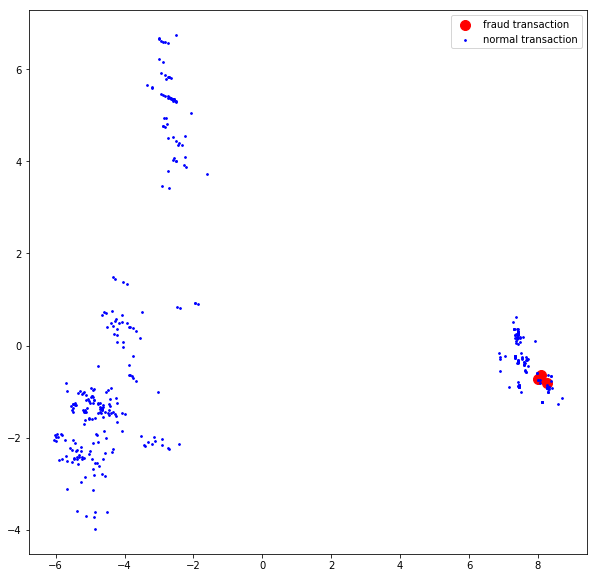

Ploting PCA on bacno-22313
(319, 75) 2.0


<Figure size 432x288 with 0 Axes>

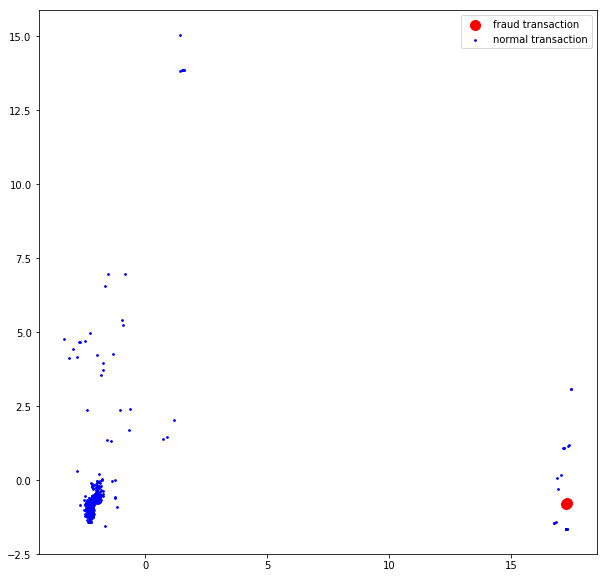

Ploting PCA on bacno-28468
(364, 75) 1.0


<Figure size 432x288 with 0 Axes>

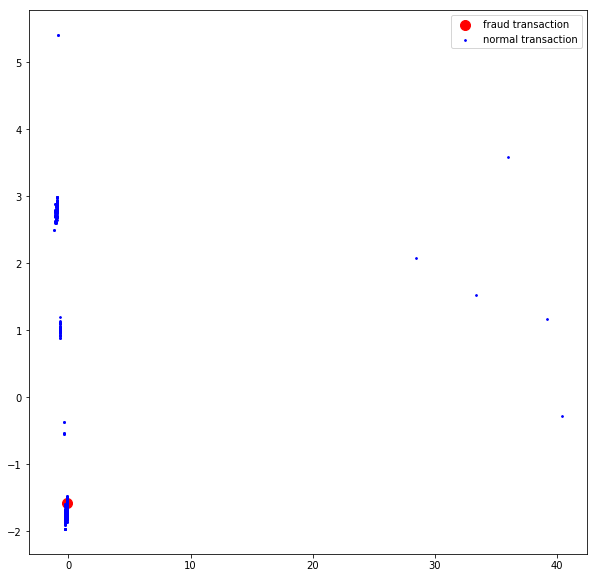

Ploting PCA on bacno-44273
(342, 75) 1.0


<Figure size 432x288 with 0 Axes>

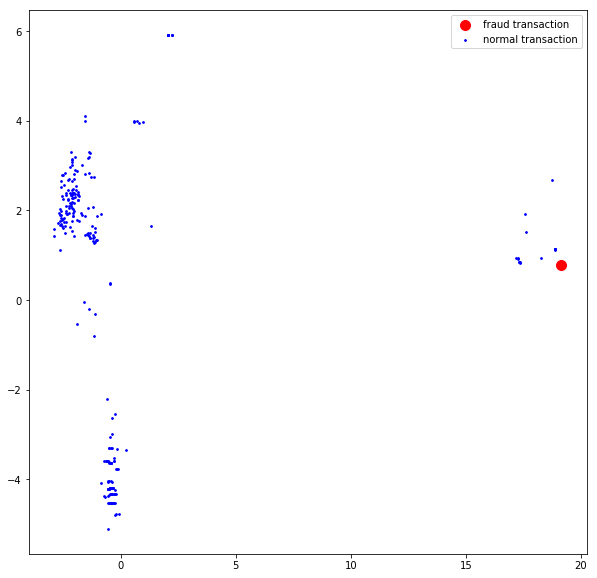

Ploting PCA on bacno-97166
(456, 75) 11.0


<Figure size 432x288 with 0 Axes>

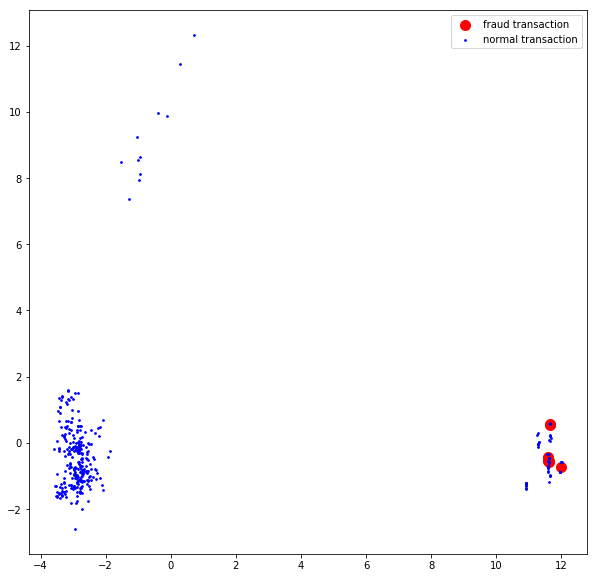

Ploting PCA on bacno-122202
(424, 75) 1.0


<Figure size 432x288 with 0 Axes>

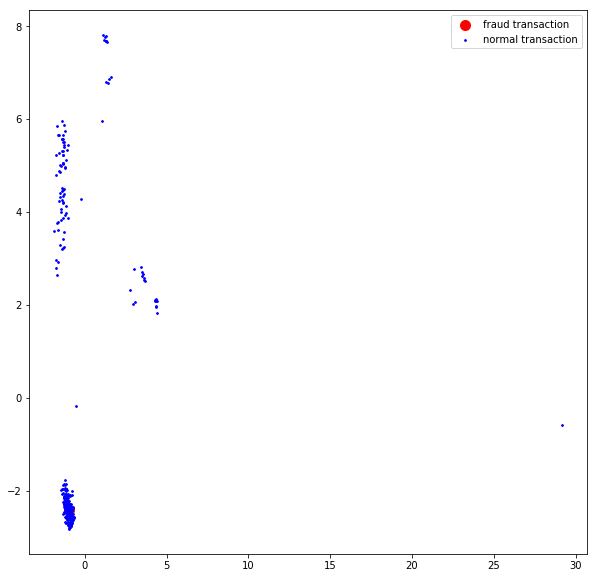

Ploting PCA on bacno-156347
(313, 75) 10.0


<Figure size 432x288 with 0 Axes>

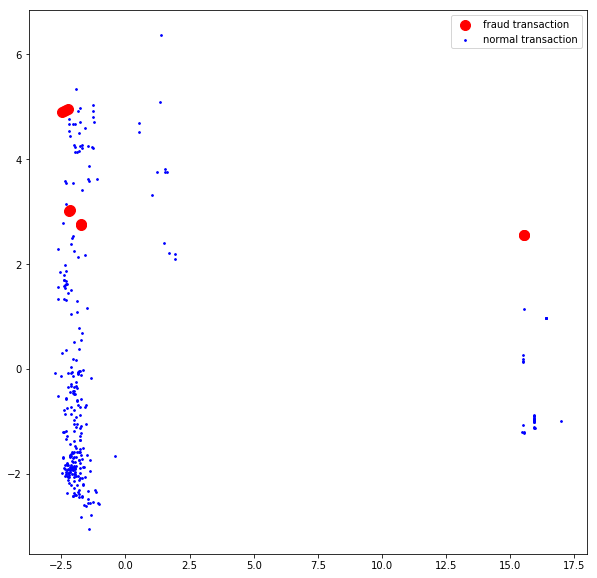

In [108]:
from sklearn.decomposition import PCA
def PCA_plot(x,label):
    x = x.drop(columns=delete_list)
    
    ## 應該先轉dummy,標準化,再PCA
#     dummy_list=['contp','etymd','stscd','hcefg']
#     dummy_list2=['stocn','scity','csmcu']#'mchno','acqic','mcc',
#     x[dummy_list] = x[dummy_list].astype(object)
#     x[dummy_list2] = x[dummy_list2].astype(object)
#     x = pd.get_dummies(x)    
    
    from sklearn.preprocessing import StandardScaler 
    stdsc = StandardScaler() 
    x = stdsc.fit_transform(x)
    print(x.shape,label.sum())

    PCA_model = PCA(n_components=2)
    train_data_pca = PCA_model.fit_transform(x)
    train_data_pca1 = train_data_pca[label==1]
    train_data_pca0 = train_data_pca[label==0]
    
    plt.clf()
    plt.figure(figsize=(10,10))
    plt.scatter(train_data_pca1[:, 0], train_data_pca1[:, 1], c='r',label='fraud transaction',s=100)
    plt.scatter(train_data_pca0[:, 0], train_data_pca0[:, 1], c='b',label='normal transaction',s=3)
    plt.legend()
    plt.show()
    
bacno_hasfraud = all_data[all_data['fraud_ind']==1]['bacno'].unique()
print(bacno_hasfraud.shape[0])
print(all_data[all_data['fraud_ind']==1].shape[0])

for i in range(bacno_hasfraud.shape[0]):
    if all_data[all_data['bacno']==bacno_hasfraud[i]].shape[0]>300:
        print('Ploting PCA on bacno-{}'.format(bacno_hasfraud[i]))
        PCA_plot(all_data[all_data['bacno']==bacno_hasfraud[i]],all_data[all_data['bacno']==bacno_hasfraud[i]]['fraud_ind'])

## TSNE, Kmeans作圖?

## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

c_ratio = y_train.sum()/y_train.shape[0]
# fit the model
clf = IsolationForest(behaviour='new', max_samples=0.8, max_features=1,
                      random_state=random_seed, contamination=c_ratio)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

y_pred_test2 = -y_pred_test
y_pred_test2[y_pred_test2==-1]=0
y_pred_test2.sum()

y_pred_train2 = -y_pred_train
y_pred_train2[y_pred_train2==-1]=0
y_pred_train2.sum()

from sklearn.metrics import f1_score
print(f1_score(y_train, y_pred_train2))
print(f1_score(y_test, y_pred_test2))

isolationtree_X_train = clf.score_samples(X_train)
isolationtree_X_test = clf.score_samples(X_test)

print(isolationtree_X_train)

## One class SVM

In [ ]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma='scale',verbose=True, random_state=random_seed)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_test.sum()

y_pred_train2 = -y_pred_train
y_pred_train2[y_pred_train2==-1]=0
y_pred_train2.sum()

from sklearn.metrics import f1_score
print(f1_score(y_train, y_pred_train2))
print(f1_score(y_test, y_pred_test2))

svm_X_train = clf.score_samples(X_train)
svm_X_test = clf.score_samples(X_test)

print(isolationtree_X_train)

## one class Kmeans

In [ ]:
# 用hinge loss(當SVM)

In [ ]:
# X_train['cents']
# encoding data

# GroupKfold
# vanilla KFold